In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

/home/marcia/anaconda3/envs/mlph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


to be tested:
number of layers
learning rate 
activation function
integration area
random vs linspace collocation points

In [2]:
class vanillaPINN(nn.Module):
    def __init__(self):
      super(vanillaPINN, self).__init__()

      # 2 fully connected layers
      self.fc1 = nn.Linear(1, 20)
      self.fc4 = nn.Linear(20, 20)
      self.fc5 = nn.Linear(20, 1)
      self.tanh = nn.Tanh()
    
    def forward(self, x):
      x = self.fc1(x)
      x = self.tanh(x)
      x = self.fc4(x)
      x = self.tanh(x)
      x = self.fc5(x)
      output = x
      return output

model= vanillaPINN()
print(model)

vanillaPINN(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
)


In [3]:
random_data = torch.rand(1)
print(random_data)
result = model(random_data)
print (result)

tensor([0.2645])
tensor([-0.0392], grad_fn=<AddBackward0>)


## Harmonic Oscillator
The harmonic oscillator is described by the differental equation
$\frac{d^2}{d t^2}x+\omega^2 x=0$

We know its solution to be 
$x=A \text{sin}(\omega t+\phi)$

In [4]:
def harmonic_analytical_solution(t, omega, A, phi):
    return A*torch.sin(omega*t+phi)

We define the loss, with a term for the residual of the DE of the harmonic oscillator

In [5]:
def loss_phys_harmonic(x_pred_collocation, t_collocation, omega):
    dxdt = torch.autograd.grad(x_pred_collocation, t_collocation, torch.ones_like(x_pred_collocation), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt, t_collocation, torch.ones_like(dxdt), create_graph=True)[0]
    return torch.mean((d2xdt2+omega**2*x_pred_collocation)**2)
    
def loss_ib(x_pred_initial, x_true_initial, dxdt_true_initial, t_initial):
    dxdt = torch.autograd.grad(x_pred_initial, t_initial, torch.ones_like(t_initial), create_graph=True)[0]
    return (x_pred_initial - x_true_initial)**2+(dxdt - dxdt_true_initial)**2

def MSE(x_pred_train, x_true_train):
    return torch.mean((x_pred_train - x_true_train)**2)
    

omega_data=1
omega_phys=1
omega_ib=1
def loss_vanilla_harmonic(x_pred_initial, x_true_initial, x_pred_train, x_true_train, x_pred_collocation, t_collocation,dxdt_true_initial, t_initial, omega):
    return omega_data*MSE(x_pred_train, x_true_train)+omega_phys*loss_phys_harmonic(x_pred_collocation, t_collocation, omega)+omega_ib*loss_ib(x_pred_initial, x_true_initial,dxdt_true_initial, t_initial)

#### Solution
Here, we know out parameter $\gamma$ in the DE and the initial condition (no additional data necessary) and let the NN learn the solution of the known DE.

In [6]:
#true distribution
omega = 1.
A = 1
phi = 0
T_interval = 12
t_range = torch.linspace(0,T_interval,100).view(-1,1).requires_grad_(True)
x_range = harmonic_analytical_solution(t_range, omega, A, phi)

#initial values
t_initial = t_range[0]
x_initial = x_range[0]
dxdt_initial = torch.tensor([omega]).requires_grad_(True)

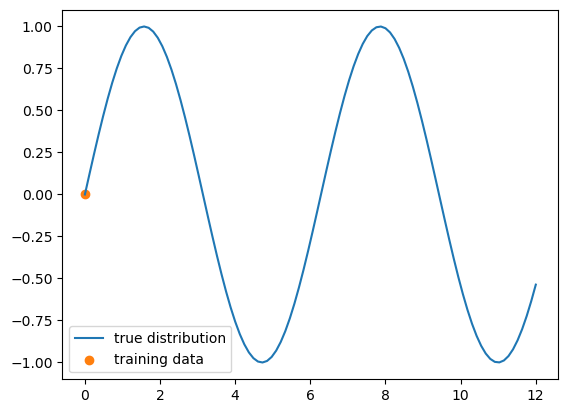

In [7]:
#plot true distribution and training data
plt.plot(t_range.detach(), x_range.detach(), label='true distribution')
plt.scatter(t_initial[0].detach(), x_initial[0].detach(), c='#ff7f0e', label='training data')
plt.legend()

In [17]:
#create collocation points ON GRID
n_collocation = 100
t_collocation = torch.linspace(0,T_interval,n_collocation).view(-1,1).requires_grad_(True)

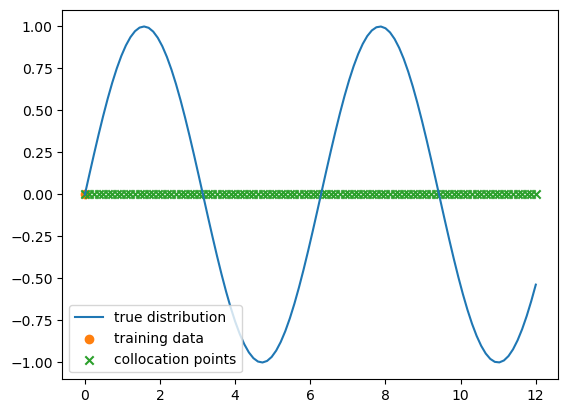

In [9]:
#plot true distribution and training data
plt.plot(t_range.detach(), x_range.detach(), label='true distribution')
plt.scatter(t_initial[0].detach(), x_initial[0].detach(), c='#ff7f0e', label='training data')
plt.scatter(t_collocation.detach(), torch.zeros(n_collocation), c='#2ca02c', marker='x', label='collocation points')
plt.legend()

tensor([[0.]], requires_grad=True)


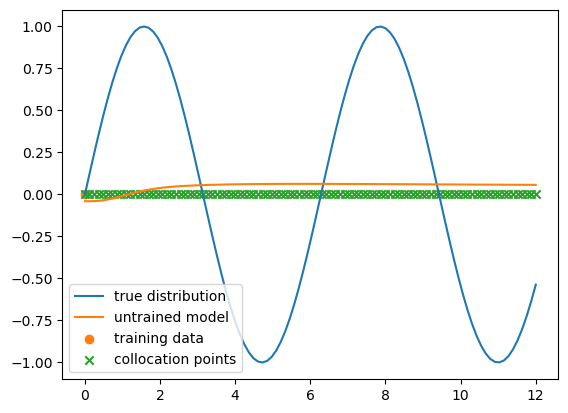

In [10]:
test=torch.tensor(0.).view(-1,1).requires_grad_(True)
print(test)
model(test)


plt.plot(t_range.detach(), x_range.detach(), label='true distribution')
plt.plot(t_range.detach(), model(t_range).detach(), label='untrained model')
plt.scatter(t_initial.detach(), x_initial.detach(), c='#ff7f0e', label='training data')
plt.scatter(t_collocation.detach(), torch.zeros(n_collocation), c='#2ca02c', marker='x', label='collocation points')
plt.legend()

In [11]:
t_train = torch.linspace(0,T_interval,20000).view(-1,1).requires_grad_(True)
dummy = torch.tensor(0.).view(-1,1).requires_grad_(True)


def train_discovery(model, loss_fn, optimizer, t_initial, x_initial, t_collocation, t_train, dxdt_true_initial):
    model.train()
    for batch in range(len(t_train)):
        optimizer.zero_grad()
        #pred_train = model(t) #make prediction
        loss = loss_fn(model(t_initial), x_initial.detach(), dummy, dummy, model(t_collocation), t_collocation, dxdt_true_initial, t_initial, omega) #calculate loss
        loss.backward()  #propagate the loss backwards
        optimizer.step() #optimize parameters
        if batch % 2000 == 0: #pront current loss
            print('iteration:', batch, '/', len(t_train))
            print('loss =',loss.item())
            plt.plot(t_range.detach(), x_range.detach(), linestyle='--', label='true distribution')
            plt.plot(t_range.detach(), model(t_range).detach(), label='current model')
            plt.scatter(t_initial.detach(), x_initial.detach(), c='#ff7f0e', label='training data')
            plt.scatter(t_collocation.detach(), torch.zeros(n_collocation), c='#2ca02c', marker='x', label='collocation points')
            plt.legend()
            plt.show()





iteration: 0 / 20000
loss = 1.0153180360794067


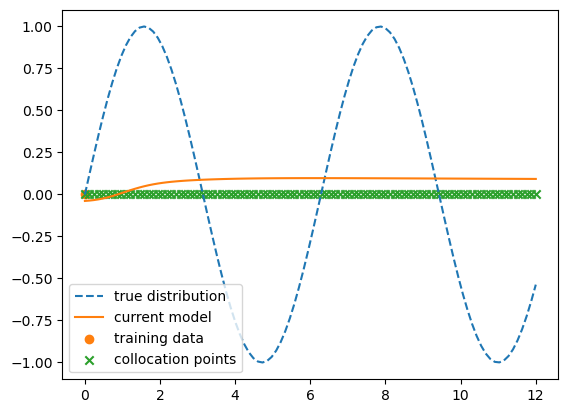

iteration: 2000 / 20000
loss = 0.023921048268675804


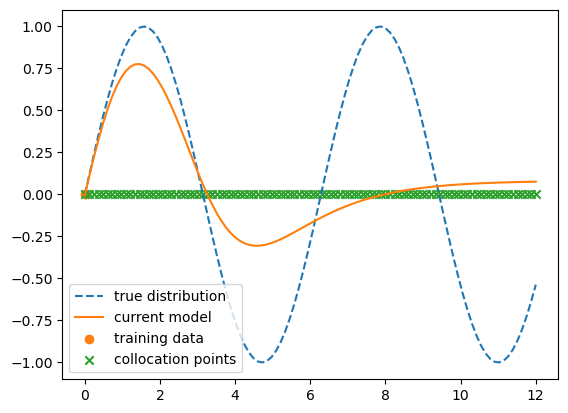

iteration: 4000 / 20000
loss = 0.014345928095281124


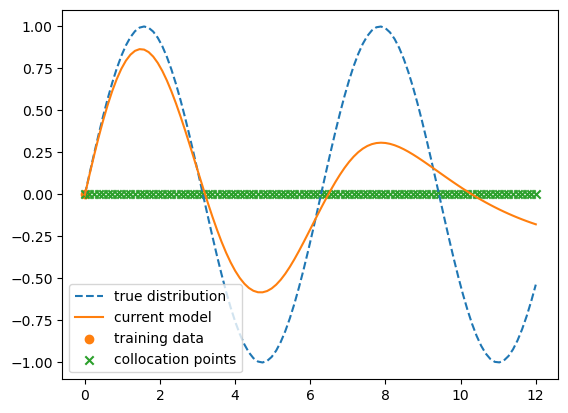

iteration: 6000 / 20000
loss = 0.013883600942790508


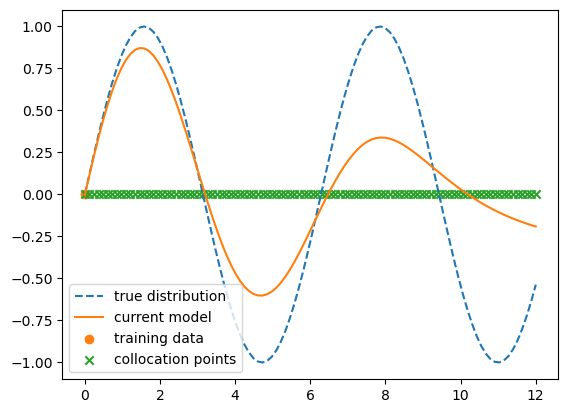

iteration: 8000 / 20000
loss = 0.01361769251525402


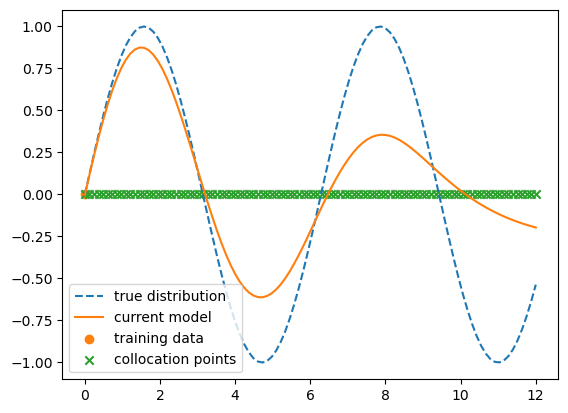

iteration: 10000 / 20000
loss = 0.011983298696577549


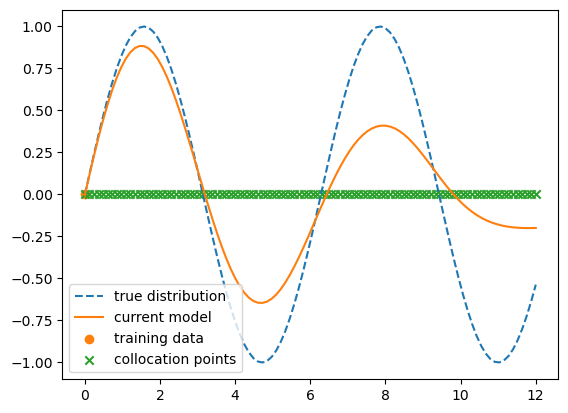

iteration: 12000 / 20000
loss = 0.00038560028770007193


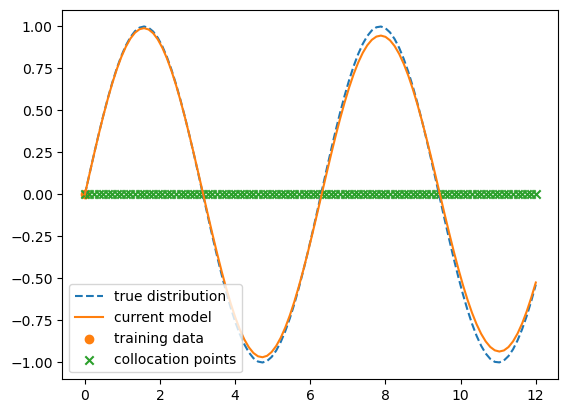

iteration: 14000 / 20000
loss = 0.00021355296485126019


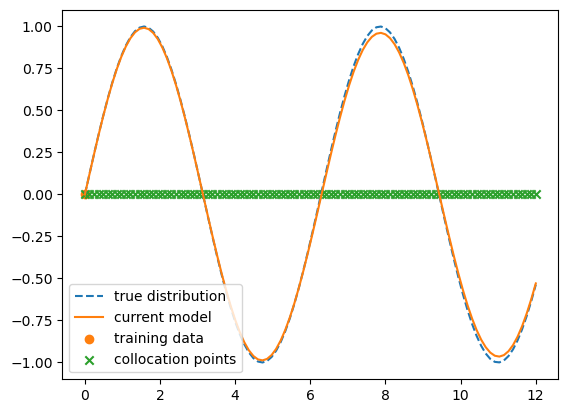

iteration: 16000 / 20000
loss = 0.00010998878860846162


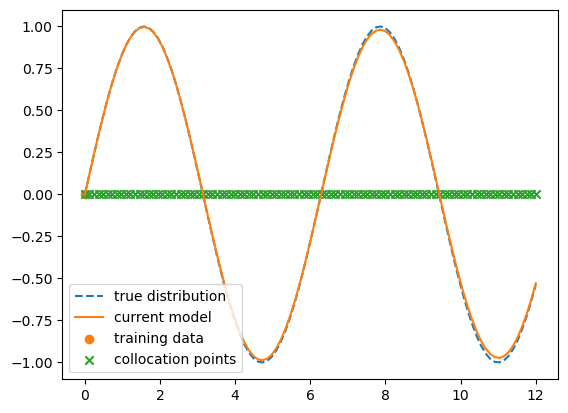

iteration: 18000 / 20000
loss = 7.579410157632083e-05


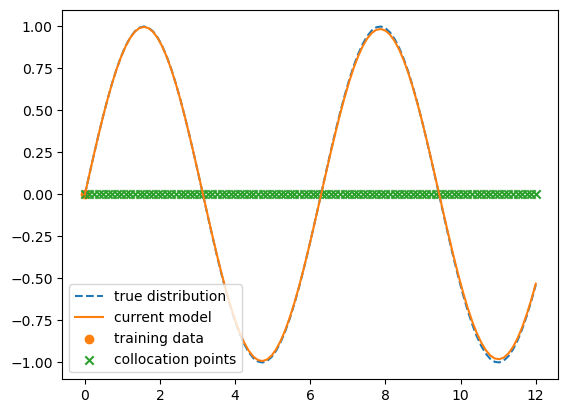

In [12]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_discovery(model, loss_vanilla_harmonic, optimizer, t_initial, x_initial, t_collocation, t_train, dxdt_initial)
